# ARIMA and Rolling Forecast



In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## 데이터 읽기와 포매팅

데이터는 3년치 월별 샴푸 판매량으로 [Data Market](https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line) 에서 다운로드 받아 저장한 CSV 파일을 사용합니다.

In [28]:
shampoo = pd.read_csv('./data/sales-of-shampoo.csv')
display(shampoo.head())
shampoo.info()

,Month,Sales of shampoo
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Month             36 non-null     object 
 1   Sales of shampoo  36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 704.0+ bytes


In [29]:
shampoo = pd.read_csv('./data/sales-of-shampoo.csv',
                     index_col='Month',
                     parse_dates=True)
display(shampoo.head())
shampoo.info()

,Sales of shampoo
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 1-01 to 3-12
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sales of shampoo  36 non-null     float64
dtypes: float64(1)
memory usage: 576.0+ bytes


In [2]:
# Month 칼럼을 읽기 위한 파서
def dateparser(x):
    return datetime.strptime('190'+x, "%Y-%m")
#    "1-01" => "1901-01"

In [30]:
shampoo = pd.read_csv('./data/sales-of-shampoo.csv',
                      index_col='Month',
                      parse_dates=True,
                      date_parser=dateparser)
display(shampoo.head())
shampoo.info()

,Sales of shampoo
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 1901-01-01 to 1903-12-01
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sales of shampoo  36 non-null     float64
dtypes: float64(1)
memory usage: 576.0 bytes


## Visualize the data

pandas 내장 플로팅 함수들로 시계열 데이터를 시각화 해봅니다. 뚜렷한 트랜드를 보이는 반면 시즌 패턴은 보이지 않습니다.

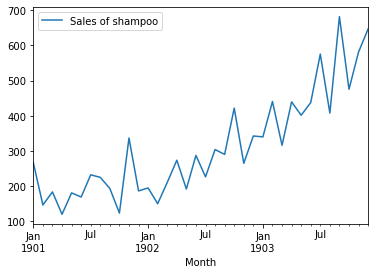

In [6]:
shampoo.plot()
plt.show()

## Testing for Stationarity

In [31]:
from statsmodels.tsa.stattools import adfuller

In [32]:
def adf_check(ts):
    result = adfuller(ts)
    if result[1] <= 0.05:
        print('Stationary {}'.format(result[1]))
    else:
        print('Non-Stationary {}'.format(result[1]))

In [33]:
adf_check(shampoo['Sales of shampoo'])

Non-Stationary 0.43398200066754483


C:\Users\Wyatt\anaconda3\envs\wyatt37\lib\site-packages\numpy\linalg\linalg.py:1855: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


테스트 결과 데이터가 stationary 특성을 보이지 않고 있음이 확인됩니다.

## Differencing

시계열 데이터에 대한 1차(first) difference 는 다음 스탭으로의 한 차원(시간단위) 만큼의 변화값의 series 입니다. pandas 를 이용하면 아주 differencing 할 수 있습니다. 1차, 2차 등 differencing 을 시도해보고 stationary 한 차원을 찾습니다.

#### First Difference

In [34]:
shampoo['1st diff'] = shampoo['Sales of shampoo'] - shampoo['Sales of shampoo'].shift(1)

In [35]:
adf_check(shampoo['1st diff'].dropna())

Stationary 1.7998574141687034e-10


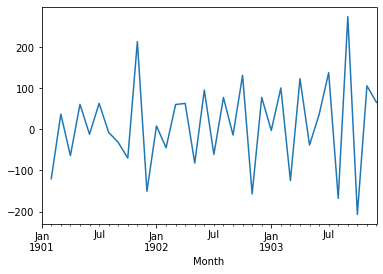

In [36]:
shampoo['1st diff'].plot()
plt.show()

#### Second Difference

In [14]:
shampoo['2nd diff'] = shampoo['1st diff'] - shampoo['1st diff'].shift()

In [15]:
adf_check(shampoo['2nd diff'].dropna())

Stationary 2.077693022525404e-30


C:\Users\Wyatt\anaconda3\envs\wyatt37\lib\site-packages\numpy\linalg\linalg.py:1855: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


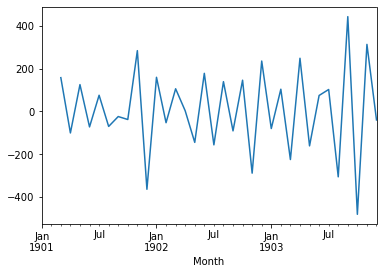

In [16]:
shampoo['2nd diff'].plot()

## Autocorrelation and Partial Autocorrelation Plots

In [17]:
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

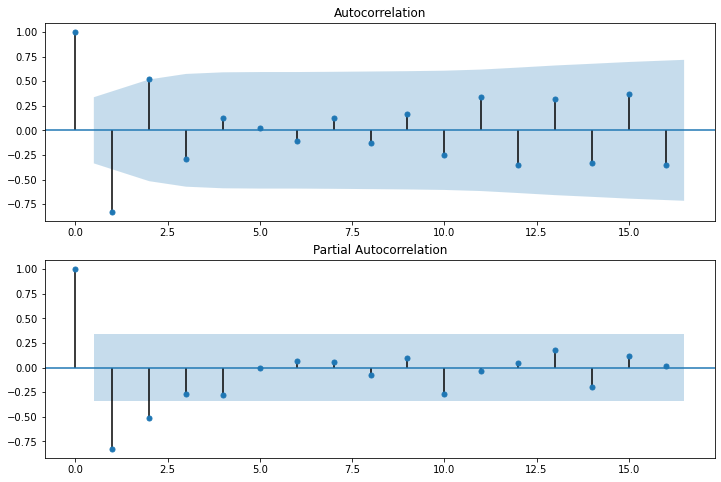

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(shampoo['2nd diff'].dropna(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(shampoo['2nd diff'].dropna(), ax=ax2, method='ywm')

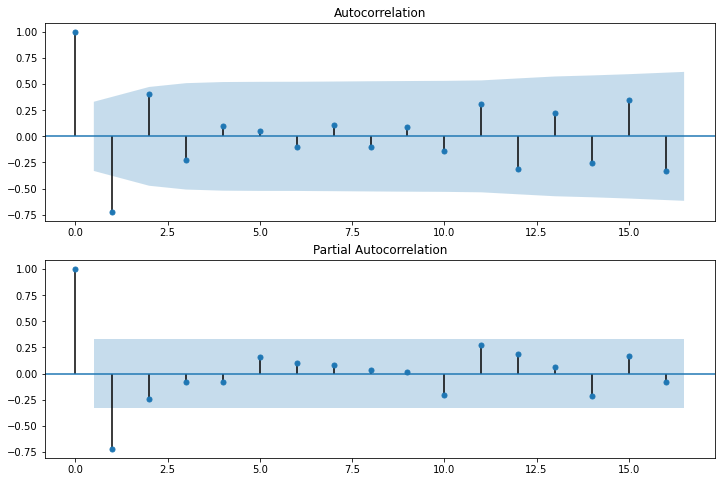

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(shampoo['1st diff'].dropna(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(shampoo['1st diff'].dropna(), ax=ax2, method='ywm')

PACF 와 ACF 에서 각각 lag 1 에 대해 강한 상관관계를 보이고 있습니다.

In [19]:
from statsmodels.tsa.arima_model import ARIMA

In [20]:
model = ARIMA(shampoo['Sales of shampoo'], order=(1,1,1), freq='MS')
model_fit = model.fit(disp=0)

In [21]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:     D.Sales of shampoo   No. Observations:                   35
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -197.233
Method:                       css-mle   S.D. of innovations             66.625
Date:                Thu, 31 Jan 2019   AIC                            402.467
Time:                        19:34:34   BIC                            408.688
Sample:                    02-01-1901   HQIC                           404.614
                         - 12-01-1903                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       12.0965      3.651      3.313      0.002       4.940      19.253
ar.L1.D.Sales of shampoo    -0.5674      0.161     -3.526      0.001      -0.883      -0.

일단 residual error 에 대해 line plot 을 그려고보 모델에 의해 파악되지 않은 트랜드 정보가 있는지 확인합니다.

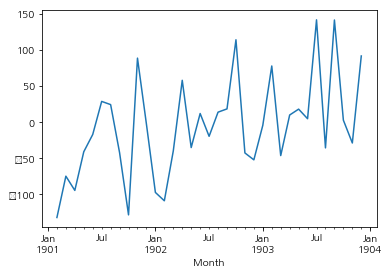

In [22]:
# plot residual errors
model_fit.resid.plot()

다음으로 residual error 에 대한 density plot 을 그리고 정규분포에 가까운지 확인합니다.

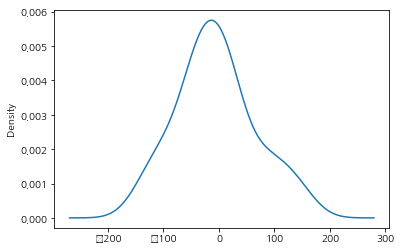

In [23]:
model_fit.resid.plot(kind='kde')

In [24]:
model_fit.resid.describe()

count     35.000000
mean      -5.505160
std       69.978598
min     -132.196527
25%      -42.395612
50%       -4.181400
75%       21.540075
max      142.155114
dtype: float64

## GridSearch
AIC 를 기준으로 최적의 p,d,q 파라메터를 찾습니다.

In [20]:
import itertools

p = range(0,5)
d = range(1,3)
q = range(0,5)

pdq = list(itertools.product(p, d, q))
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3),
 (3, 2, 4),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 2, 0),
 (4, 2, 1),
 (4, 2, 2),
 (4, 2, 3),
 (4, 2, 4)]

In [26]:
aic_params = []

for param in pdq:
    try:
        mod = ARIMA(shampoo['Sales of shampoo'], order=param)
        results = mod.fit(disp=0)
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
        aic_params.append((results.aic, param,))
    except:
        pass

/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[

ARIMA(0, 1, 0) - AIC:430.87311187552797
ARIMA(0, 1, 1) - AIC:409.0126622411526
ARIMA(0, 2, 0) - AIC:461.1578257086931
ARIMA(0, 2, 1) - AIC:424.58251674821
ARIMA(1, 1, 0) - AIC:406.02228959235015
ARIMA(1, 1, 1) - AIC:402.4666524179953


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided

ARIMA(1, 1, 2) - AIC:401.5247943798928


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 3) - AIC:403.52417287508956
ARIMA(1, 2, 0) - AIC:423.90008603782104


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided

ARIMA(1, 2, 3) - AIC:nan


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/home/lyle/anaconda3/envs/tsa/lib/py

ARIMA(1, 2, 4) - AIC:nan
ARIMA(2, 1, 0) - AIC:403.6275641166603
ARIMA(2, 1, 1) - AIC:404.28621423318384


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided

ARIMA(2, 2, 0) - AIC:412.99938249704275


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1) - AIC:396.65262382813955


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 3) - AIC:389.68350650892074
ARIMA(3, 1, 0) - AIC:404.6924591816878


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided

ARIMA(3, 1, 1) - AIC:406.1395443929549


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided

ARIMA(3, 2, 0) - AIC:410.9109265845758
ARIMA(3, 2, 1) - AIC:396.30623658353767
ARIMA(3, 2, 2) - AIC:nan


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, 

ARIMA(3, 2, 3) - AIC:406.104929451703
ARIMA(4, 1, 0) - AIC:404.78676855669903
ARIMA(4, 1, 1) - AIC:406.5796403612012


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(4, 1, 2) - AIC:400.2307795387626


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(4, 1, 3) - AIC:400.65677258685764


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(4, 1, 4) - AIC:406.3808484357497


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(4, 2, 0) - AIC:403.9482289506873


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(4, 2, 1) - AIC:393.1540750944809


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, 

ARIMA(4, 2, 2) - AIC:nan
ARIMA(4, 2, 3) - AIC:402.5718428919337


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [27]:
# ARIMA(4,2,1)
model = ARIMA(shampoo['Sales of shampoo'], order=(4,2,1))
results = model.fit()
print(results.summary())

/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARIMA Model Results                              
Dep. Variable:     D2.Sales of shampoo   No. Observations:                   34
Model:                  ARIMA(4, 2, 1)   Log Likelihood                -189.577
Method:                        css-mle   S.D. of innovations             56.216
Date:                 Thu, 31 Jan 2019   AIC                            393.154
Time:                         19:34:44   BIC                            403.839
Sample:                     03-01-1901   HQIC                           396.798
                          - 12-01-1903                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.8979      0.246      3.654      0.001       0.416       1.380
ar.L1.D2.Sales of shampoo    -1.2964      0.161     -8.036      0.000      -1.

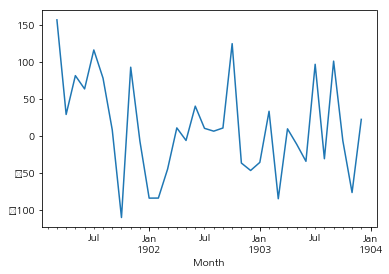

In [28]:
results.resid.plot()

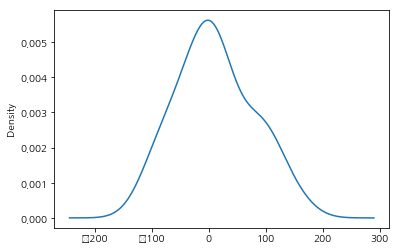

In [29]:
results.resid.plot(kind='kde')

In [30]:
results.resid.describe()

count     34.000000
mean      11.226048
std       66.730384
min     -110.457557
25%      -35.653924
50%        8.525816
75%       57.335824
max      156.402102
dtype: float64

## Rolling Forecast ARIMA Model

ARIMA 모델로 미래 데이터를 예측하기 위해 predict() 함수를 사용합니다. 이 함수는 파라메터로 예측할 타임스텝을(steps) 필요로하는데 학습 데이터에대한 인덱스 상대값을 입력하면 됩니다. 가령 모델을 학습하기 위해 100개의 학습데이터를 사용했다면 다음 스텝 예측값의 인덱스는 start=101, end=101 이 됩니다. 예측 결과 리턴값은 하나의 예측값을 포함한 배열이 됩니다.

또는 forcast() 함수로 파라메터 없이 다음 한 스템의 데이터를 예측할 수 있습니다. 

데이터를 train 과 test 로 나눈 뒤 train 데이터로 모델을 학습시키고 test 데이터의 각 시점에 해당하는 예측 해봅니다. 그러기 위해 새로운 actual value 를 하나씩 수집하면서 그와 함께 앞선 시점의 데이터로 ARIMA 모델을 학습과 예측을 반복하는 rolling forecast 를 수행하게 됩니다.

아래 코드에서 수동으로 관측값을을 history 변수에 추가해가면서 모델링과 예측을 반복하면서 prediction 과 expected value 를 출력하고 최종적으로 그에 따른 mean squared error (MSE) 를 계산합니다.

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt

X = shampoo['Sales of shampoo'].values

# train , test 데이터를 2:1 로 split
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

# 학습시킬 데이터
history = [x for x in train]
predictions = list()

# test 데이터만큼 모델링 & 예측
for t in range(len(test)):
    model = ARIMA(history, order=(4,2,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    
    # predicted value
    yhat = output[0]
    predictions.append(yhat)
    
    # actual value
    obs = test[t]
    
    # actual value 를 다음 스텝에서 학습할 데이터에 추가
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % sqrt(error))

predicted=399.145200, expected=342.300000
predicted=354.296566, expected=339.700000
predicted=429.967876, expected=440.400000
predicted=392.634689, expected=315.900000
predicted=420.191849, expected=439.300000
predicted=397.585316, expected=401.300000
predicted=487.892625, expected=437.400000
predicted=434.160085, expected=575.500000
predicted=467.057786, expected=407.600000


/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=568.082759, expected=682.000000
predicted=468.024731, expected=475.300000
predicted=687.491691, expected=581.300000
predicted=617.839224, expected=646.900000
Test RMSE: 68.519


실제값(파란색)과 rolling forecast(red) 결과를 비교해보면 트렌드를 어느정도 예측하고 있음을 확인할 수 있습니다.

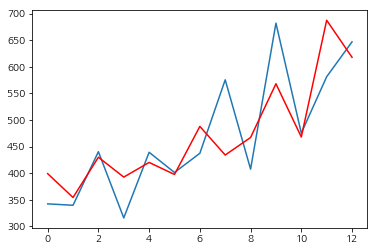

In [32]:
plt.plot(test)
plt.plot(predictions, color='red')